In [3]:
import os
import pandas as pd

data = pd.read_csv('labels/Data_Entry_2017_v2020.csv')
data = data.rename(columns={'Finding Label': 'Finding Labels'})


exclude_labels = [
    'Hernia', 'Pneumonia', 'Edema', 'Cardiomegaly', 'Consolidation', 
    'Pleural_Thickening', 'Fibrosis', 'Emphysema', 'Pneumothorax', 
    'Mass', 'No Finding'
]

filtered_data = data[~data['Finding Labels'].str.contains('|'.join(exclude_labels), na=False)]
filtered_data = filtered_data[~filtered_data['Finding Labels'].str.contains(r'\|', na=False)]


filtered_data = filtered_data[['Image Index', 'Finding Labels']]


base_dir = 'xray_data'


def find_image_path(image_index, base_dir):
   
    for subfolder in sorted(os.listdir(base_dir)): 
        subfolder_path = os.path.join(base_dir, subfolder)
        nested_images_path = os.path.join(subfolder_path, 'images')

        if os.path.isdir(nested_images_path):
            image_path = os.path.join(nested_images_path, image_index)
            if os.path.exists(image_path): 
                return image_path

    return None

filtered_data['Image Path'] = filtered_data['Image Index'].apply(lambda x: find_image_path(x, base_dir))


num_invalid = filtered_data['Image Path'].isna().sum()
num_valid = filtered_data['Image Path'].notna().sum()
print(f"Number of invalid paths: {num_invalid}")
print(f"Number of valid paths: {num_valid}")


filtered_data = filtered_data.dropna(subset=['Image Path']).reset_index(drop=True)


print(filtered_data.head())


Number of invalid paths: 0
Number of valid paths: 20422
        Image Index Finding Labels  \
0  00000005_006.png   Infiltration   
1  00000008_002.png         Nodule   
2  00000010_000.png   Infiltration   
3  00000011_000.png       Effusion   
4  00000011_005.png   Infiltration   

                                     Image Path  
0  xray_data/images_001/images/00000005_006.png  
1  xray_data/images_001/images/00000008_002.png  
2  xray_data/images_001/images/00000010_000.png  
3  xray_data/images_001/images/00000011_000.png  
4  xray_data/images_001/images/00000011_005.png  


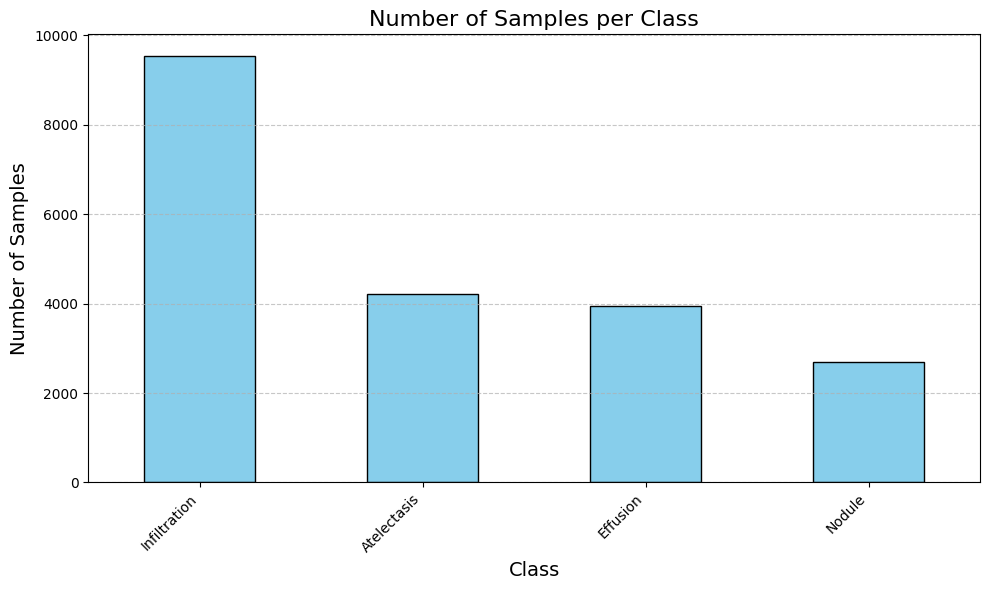

In [10]:
import matplotlib.pyplot as plt
from PIL import Image


class_counts = filtered_data['Finding Labels'].value_counts()


plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Samples per Class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(rotation=45, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.savefig('results/class_dist.png', dpi=300)
plt.show()


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample




# 80% train and 20% temporary
train_df, temp_data = train_test_split(
    filtered_data, 
    test_size=0.20,  
    random_state=42, 
    stratify=filtered_data['Finding Labels']  
)

# split 50% of temp into val 10% and test 10%
valid_df, test_data = train_test_split(
    temp_data, 
    test_size=0.50,  
    random_state=42, 
    stratify=temp_data['Finding Labels']  
)



print("Training set distribution:")
print(train_df['Finding Labels'].value_counts())
print("\nValidation set distribution:")
print(valid_df['Finding Labels'].value_counts())
print("n\Test set distribution:")
print(test_data['Finding Labels'].value_counts())

label_to_index = {label: idx for idx, label in enumerate(filtered_data['Finding Labels'].unique())}
index_to_label = {idx: label for label, idx in label_to_index.items()}  # Reverse mapping


train_df['Finding Labels'] = train_df['Finding Labels'].map(label_to_index)
valid_df['Finding Labels'] = valid_df['Finding Labels'].map(label_to_index)
test_data['Finding Labels'] = test_data['Finding Labels'].map(label_to_index)



print("\nLabel to Index Mapping:")
for label, idx in label_to_index.items():
    print(f"Label: {label}, Index: {idx}")






Training set distribution:
Infiltration    7637
Atelectasis     3372
Effusion        3164
Nodule          2164
Name: Finding Labels, dtype: int64

Validation set distribution:
Infiltration    955
Atelectasis     421
Effusion        395
Nodule          271
Name: Finding Labels, dtype: int64
n\Test set distribution:
Infiltration    955
Atelectasis     422
Effusion        396
Nodule          270
Name: Finding Labels, dtype: int64

Label to Index Mapping:
Label: Infiltration, Index: 0
Label: Nodule, Index: 1
Label: Effusion, Index: 2
Label: Atelectasis, Index: 3


In [14]:
def downsample_data(train_df, label_name, label_to_index, target_downsample_count=500):
    
    no_finding_label = label_to_index[label_name]
    no_finding_samples = train_df[train_df['Finding Labels'] == no_finding_label]
    other_classes = train_df[train_df['Finding Labels'] != no_finding_label]

    downsampled_no_finding = no_finding_samples.sample(n=target_downsample_count, random_state=42)

    final_train_df = pd.concat([downsampled_no_finding, other_classes])
    final_train_df = final_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return final_train_df


train_df = downsample_data(
    train_df=train_df,
    label_name='Infiltration',
    label_to_index=label_to_index,
    target_downsample_count=3400
)


class_counts_after_sampling = train_df['Finding Labels'].value_counts()

print("Label | Index | Number of Samples")
print("-" * 40)
for label, idx in label_to_index.items():
    count = class_counts_after_sampling[idx] if idx in class_counts_after_sampling else 0
    print(f"{label:<15} | {idx:<5} | {count:<10}")

    
imbalance_ratio = class_counts_after_sampling.max() / class_counts_after_sampling.min()
print("Imbalance Ratio:", imbalance_ratio)


Label | Index | Number of Samples
----------------------------------------
Infiltration    | 0     | 3400      
Nodule          | 1     | 2164      
Effusion        | 2     | 3164      
Atelectasis     | 3     | 3372      
Imbalance Ratio: 1.5711645101663585


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from torchvision import transforms


class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, transform=None):
    
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

        img_path = self.dataframe.iloc[idx]['Image Path']
        label = self.dataframe.iloc[idx]['Finding Labels']

    
        image = Image.open(img_path).convert("RGB")  

        if self.transform:
            image = self.transform(image)

        label_tensor = torch.tensor(label, dtype=torch.long)

        return image, label_tensor

In [ ]:
def compute_mean_std(loader):
    
    channel_sum = torch.zeros(3)  # 3 channels (RGB)
    channel_squared_sum = torch.zeros(3)
    num_batches = 0
    num_pixels = 0

    for images, _ in loader: 
        num_batches += 1
        num_pixels += images.size(0) * images.size(2) * images.size(3) 
        channel_sum += images.sum(dim=[0, 2, 3]) 
        channel_squared_sum += (images ** 2).sum(dim=[0, 2, 3])
    mean = channel_sum / num_pixels
    std = torch.sqrt(channel_squared_sum / num_pixels - mean ** 2)

    return mean, std

    
mean_std_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()  
])


unnormalized_train_dataset = ChestXrayDataset(train_df, transform=mean_std_transforms)
unnormalized_train_loader = DataLoader(unnormalized_train_dataset, batch_size=16, shuffle=False, num_workers=4)


mean, std = compute_mean_std(unnormalized_train_loader)
print(mean)
print(std)

In [16]:

        


train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.4972, 0.4972, 0.4972], std=[0.2473, 0.2473, 0.2473]) # use the mean and std computed above
    
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4972, 0.4972, 0.4972], std=[0.2473, 0.2473, 0.2473]) # mean and std from train
])


train_dataset = ChestXrayDataset(train_df, transform=train_transforms)
val_dataset = ChestXrayDataset(valid_df, transform=val_transforms)
test_dataset = ChestXrayDataset(test_data, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)


In [17]:
import torch
import torch.nn as nn

class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
       
        # Conv. layers for feature extraction 
        self.features = nn.Sequential(
            # Block 1 - Conv 1 and 2
            nn.Conv2d(3, 64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  

            # Block 2 - Conv 3 qnd 4
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), 

            # Block 3 - Conv 5, 6 and 7
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  

            # Block 4 - Conv 8, 9 and 10
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  

            # Block 5 - Conv 11,12 qnd 13
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )

        # Fully connected layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(7 * 7 * 512, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),  
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)  
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)

        return x





In [18]:

num_classes = len(train_df['Finding Labels'].unique())

model = VGG16(num_classes=num_classes)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [19]:
import torch
from sklearn.metrics import f1_score



num_epochs = 20
avg_train_loss = []
avg_train_acc = []
avg_val_loss = []
avg_val_acc = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images) 
        loss = criterion(outputs, labels)

       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1) 
        total_train += labels.size(0) 
        correct_train += (predicted == labels).sum().item() 


    epoch_train_loss = running_loss/len(train_loader)
    avg_train_loss.append(epoch_train_loss)

    epoch_train_acc = correct_train / total_train
    avg_train_acc.append(epoch_train_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train acc: {epoch_train_acc:.4f}")

    model.eval()
    correct = 0
    total = 0
    val_loss =0.0

    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
    
            outputs = model(images)
            _, predicted = torch.max(outputs, 1) 
            
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            

            
    epoch_val_loss = val_loss/len(val_loader)
    avg_val_loss.append(epoch_val_loss)

    epoch_val_acc = correct/total
    avg_val_acc.append(epoch_val_acc)


    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {epoch_val_loss:.4f}, Val acc: {epoch_val_acc:.4f}")



print("Finished training")


Epoch [1/20], Train Loss: 1.4260, Train acc: 0.2800
Epoch [1/20], Val Loss: 1.3792, Val acc: 0.2071
Epoch [2/20], Train Loss: 1.3719, Train acc: 0.3018
Epoch [2/20], Val Loss: 1.3237, Val acc: 0.3790
Epoch [3/20], Train Loss: 1.3351, Train acc: 0.3660
Epoch [3/20], Val Loss: 1.2927, Val acc: 0.4143
Epoch [4/20], Train Loss: 1.3079, Train acc: 0.4032
Epoch [4/20], Val Loss: 1.2598, Val acc: 0.4383
Epoch [5/20], Train Loss: 1.2886, Train acc: 0.4270
Epoch [5/20], Val Loss: 1.2970, Val acc: 0.3893
Epoch [6/20], Train Loss: 1.2687, Train acc: 0.4427
Epoch [6/20], Val Loss: 1.2342, Val acc: 0.4701
Epoch [7/20], Train Loss: 1.2520, Train acc: 0.4531
Epoch [7/20], Val Loss: 1.2715, Val acc: 0.4476
Epoch [8/20], Train Loss: 1.2439, Train acc: 0.4629
Epoch [8/20], Val Loss: 1.2175, Val acc: 0.4853
Epoch [9/20], Train Loss: 1.2296, Train acc: 0.4700
Epoch [9/20], Val Loss: 1.2643, Val acc: 0.4476
Epoch [10/20], Train Loss: 1.2133, Train acc: 0.4874
Epoch [10/20], Val Loss: 1.2220, Val acc: 0.492

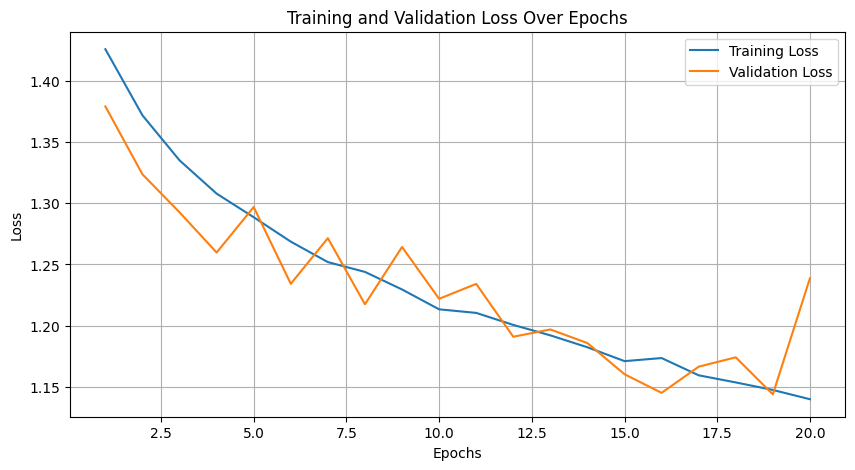

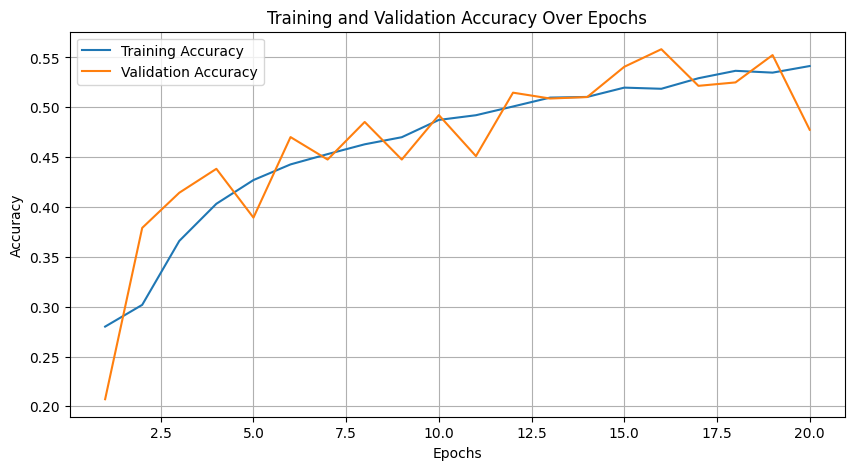

In [20]:
import matplotlib.pyplot as plt


epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, avg_train_loss, label='Training Loss')
plt.plot(epochs, avg_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)


#plt.savefig('results/vgg_lossplot_4labels.png', dpi=300) 
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, avg_train_acc, label='Training Accuracy')
plt.plot(epochs, avg_val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

#plt.savefig('results/vgg_accplot_4labels.png', dpi=300) 
plt.show()


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

evaluate_model(model, test_loader)

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, roc_auc_score
import numpy as np
class_names = list(label_to_index.keys())


all_preds = []
all_labels = []
all_probs = [] 

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  
        all_probs.extend(probabilities.cpu().numpy())
       
        _, predicted = torch.max(outputs, 1)  
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


all_probs = np.array(all_probs) 
all_labels = np.array(all_labels) 


accuracy = 100 * correct / total


precision = precision_score(all_labels, all_preds, average='weighted')  
recall = recall_score(all_labels, all_preds, average='weighted')        
f1 = f1_score(all_labels, all_preds, average='weighted')                


auc_per_class = []
for i in range(len(class_names)):
    true_binary = (all_labels == i).astype(int)  
    auc = roc_auc_score(true_binary, all_probs[:, i])
    auc_per_class.append(auc)


mean_auc = np.mean(auc_per_class)


print(f"Validation Accuracy: {accuracy:.2f}%")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1-Score: {f1:.4f}")
print(f"Mean AUC: {mean_auc:.4f}")
print(f"AUC per class: {dict(zip(class_names, auc_per_class))}")

report = classification_report(all_labels, all_preds, target_names=class_names)


print("\nClassification Report:")
print(report)




Validation Accuracy: 48.51%
Validation Precision: 0.5487
Validation Recall: 0.4851
Validation F1-Score: 0.4723
Mean AUC: 0.7583
AUC per class: {'Infiltration': 0.7430686017862642, 'Nodule': 0.6787595830461031, 'Effusion': 0.8536534133073294, 'Atelectasis': 0.7575760676663811}

Classification Report:
              precision    recall  f1-score   support

Infiltration       0.73      0.38      0.50       955
      Nodule       0.30      0.16      0.20       270
    Effusion       0.44      0.79      0.57       396
 Atelectasis       0.39      0.64      0.48       422

    accuracy                           0.49      2043
   macro avg       0.47      0.49      0.44      2043
weighted avg       0.55      0.49      0.47      2043



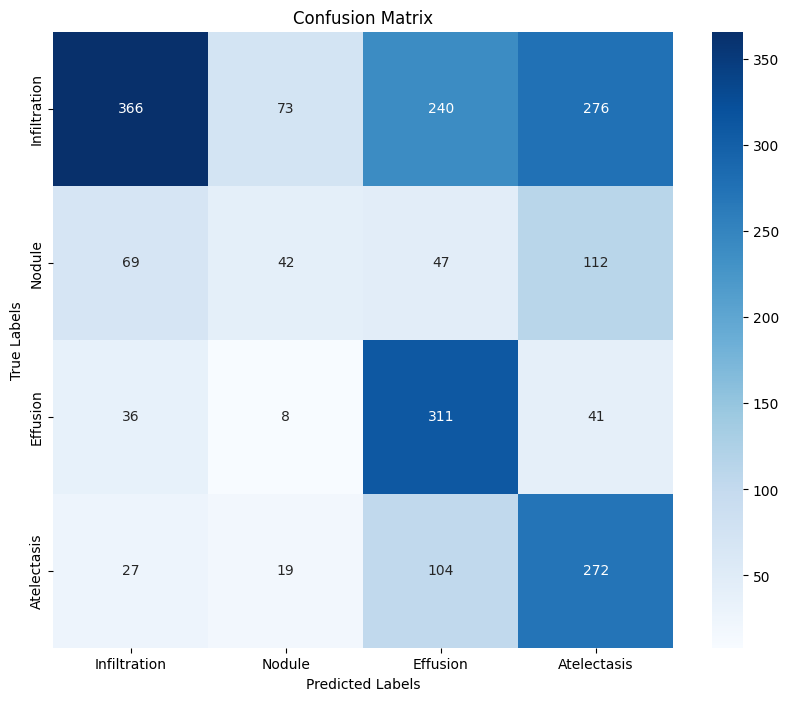

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('results/confusion_matrix_balanced.png')
plt.show()


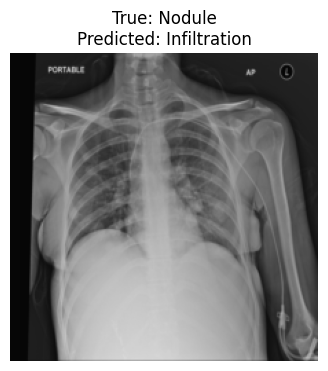

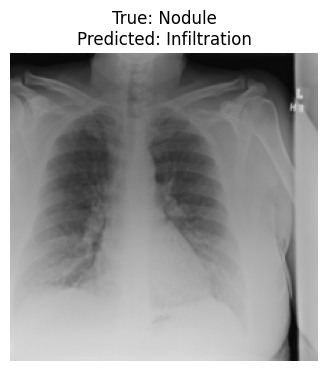

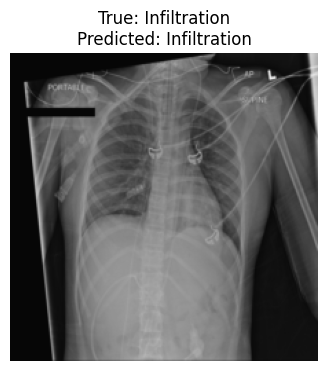

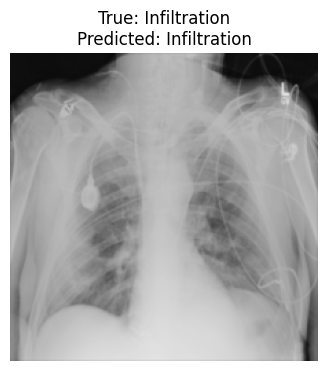

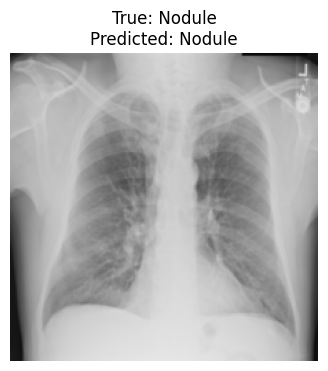

In [13]:
import matplotlib.pyplot as plt

def plot_predictions(model, test_loader, class_names, device, num_images=5):
    model.eval()
    images_shown = 0
    with torch.no_grad():
        for images, labels in test_loader:
            if images_shown >= num_images:
                break  
            
            images, labels = images.to(device), labels.to(device)

            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

           
            images = images.cpu()
            labels = labels.cpu()
            predicted = predicted.cpu()

            for idx in range(images.size(0)):
                if images_shown >= num_images:
                    break
                
                img = images[idx].permute(1, 2, 0).numpy() 
                img = img * 0.229 + 0.485  
                true_label = class_names[labels[idx].item()]
                predicted_label = class_names[predicted[idx].item()]

        
                plt.figure(figsize=(4, 4))
                plt.imshow(img)
                plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
                plt.axis('off')
                plt.show()

                images_shown += 1


plot_predictions(model, test_loader, class_names, device, num_images=5)
